#Dataset preparation

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn import model_selection

from numpy import argmax

In [3]:
df = pd.read_csv('../dataset/train.csv')

In [4]:
#We add the new 14 days features
weather_names =['_temperature_','_rain_mm_','_humidity_','_wind_speed_','_pressure_']

for name in weather_names:
  df['max'+name+'prev14d']=df['max'+name+'prev7d']
  df['max'+name+'prev7d_shift']=df['max'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df['DATE']>'2019-04-16', 'max'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['max'+name+'prev7d','max'+name+'prev7d_shift']].max(axis=1)
  df=df.drop(columns=['max'+name+'prev7d_shift'])

  df['min'+name+'prev14d']=df['min'+name+'prev7d']
  df['min'+name+'prev7d_shift']=df['min'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', 'min'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['min'+name+'prev7d','min'+name+'prev7d_shift']].min(axis=1)
  df=df.drop(columns=['min'+name+'prev7d_shift'])

  df['mean'+name+'prev14d']=df['mean'+name+'prev7d']
  df['mean'+name+'prev7d_shift']=df['mean'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', 'mean'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['mean'+name+'prev7d','mean'+name+'prev7d_shift']].mean(axis=1)
  df=df.drop(columns=['mean'+name+'prev7d_shift'])

persistance_names =['equipment','fire/smoke','ge','power','temperature']

for name in persistance_names:
  df[name+'_max_persistance_prev14d']=df[name+'_max_persistance_prev7d']
  df[name+'_max_persistance_prev7d_shift']=df[name+'_max_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_max_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_max_persistance_prev7d',name+'_max_persistance_prev7d_shift']].max(axis=1)
  df=df.drop(columns=[name+'_max_persistance_prev7d_shift'])
  
  df[name+'_min_persistance_prev14d']=df[name+'_min_persistance_prev7d']
  df[name+'_min_persistance_prev7d_shift']=df[name+'_min_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_min_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_min_persistance_prev7d',name+'_min_persistance_prev7d_shift']].min(axis=1)
  df=df.drop(columns=[name+'_min_persistance_prev7d_shift'])

  df[name+'_mean_persistance_prev14d']=df[name+'_mean_persistance_prev7d']
  df[name+'_mean_persistance_prev7d_shift']=df[name+'_mean_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_mean_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_mean_persistance_prev7d',name+'_mean_persistance_prev7d_shift']].mean(axis=1)
  df=df.drop(columns=[name+'_mean_persistance_prev7d_shift'])

In [5]:
#drop unused columns
df = df.drop(columns='CELL_TYPE_TRP') #all zeros
df = df.drop(columns='SITE_ID')

#process data feature
df['DATE'] = pd.to_datetime(df['DATE'])
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day
df['year'] = df['DATE'].dt.year % 2019
df = df.drop(columns='DATE')

In [6]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,25))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#Random forest 14d

Random forest using only the feature with 14day time frame

In [7]:
df_14d = df[[col for col in df.columns if '3d' not in col and '7d' not in col]]
df_14d.head()

,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_f_next14d,max_temperature_f_next14d,min_temperature_f_next14d,mean_rain_mm_f_next14d,max_rain_mm_f_next14d,min_rain_mm_f_next14d,mean_humidity_f_next14d,max_humidity_f_next14d,min_humidity_f_next14d,mean_wind_speed_f_next14d,max_wind_speed_f_next14d,min_wind_speed_f_next14d,mean_pressure_f_next14d,max_pressure_f_next14d,min_pressure_f_next14d,equipment_sum_alarms_prev14d,fire/smoke_sum_alarms_prev14d,ge_sum_alarms_prev14d,power_sum_alarms_prev14d,temperature_sum_alarms_prev14d,skew_equipment_alarms_prev14d,skew_fire/smoke_alarms_prev14d,skew_ge_alarms_prev14d,skew_power_alarms_prev14d,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d,max_temperature_prev14d,min_temperature_prev14d,mean_temperature_prev14d,max_rain_mm_prev14d,min_rain_mm_prev14d,mean_rain_mm_prev14d,max_humidity_prev14d,min_humidity_prev14d,mean_humidity_prev14d,max_wind_speed_prev14d,min_wind_speed_prev14d,mean_wind_speed_prev14d,max_pressure_prev14d,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year
0,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,8.00,12.0,5.0,4.79,19.6,0.1,74.29,89.0,58.0,12.86,17.0,5.0,1020.71,1028.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,14.0,6.0,10.29,8.5,0.0,1.33,81.0,45.0,62.71,16.0,5.0,11.43,1022.0,1006.0,1013.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,10,0
1,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,8.50,16.0,5.0,3.52,12.5,0.1,72.93,89.0,58.0,12.57,17.0,5.0,1021.71,1028.0,1013.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,9.0,11.71,8.5,0.0,1.90,81.0,51.0,66.43,16.0,5.0,11.57,1017.0,1006.0,1010.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,11,0
2,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,9.36,20.0,5.0,3.63,12.5,0.1,72.00,89.0,58.0,12.29,17.0,5.0,1022.14,1028.0,1016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,9.0,11.57,19.6,0.0,4.70,88.0,58.0,71.71,16.0,5.0,11.71,1015.0,1006.0,1009.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,12,0
3,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,10.57,22.0,5.0,3.40,12.5,0.1,70.07,89.0,58.0,12.14,17.0,5.0,1021.86,1028.0,1012.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,8.0,11.29,19.6,0.0,4.77,88.0,58.0,74.29,16.0,5.0,11.43,1013.0,1006.0,1009.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,13,0
4,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,11.50,22.0,5.0,3.49,12.5,0.1,69.07,89.0,58.0,11.64,17.0,5.0,1021.29,1028.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,5.0,10.57,19.6,0.3,5.39,88.0,58.0,77.29,15.0,5.0,10.86,1016.0,1006.0,1009.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,14,0


In [8]:
X = df_14d.drop(columns=['aircon_sum_target_next14d'])
y = df_14d['aircon_sum_target_next14d']

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0, stratify = y)

In [10]:
clf_RandomForest = RandomForestClassifier(n_estimators = 20, random_state=0)
clf_RandomForest.fit(X_train, y_train)
y_pred = clf_RandomForest.predict(X_test)

Accuracy:  0.9961886367294382
Precision:  0.8671497584541062
Recall:  0.40066964285714285
F1 score:  0.5480916030534351


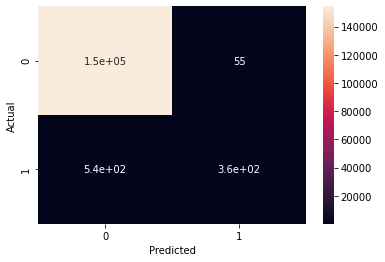

In [14]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Precision: ',metrics.precision_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred))
print('F1 score: ',metrics.f1_score(y_test, y_pred))

plt.show()

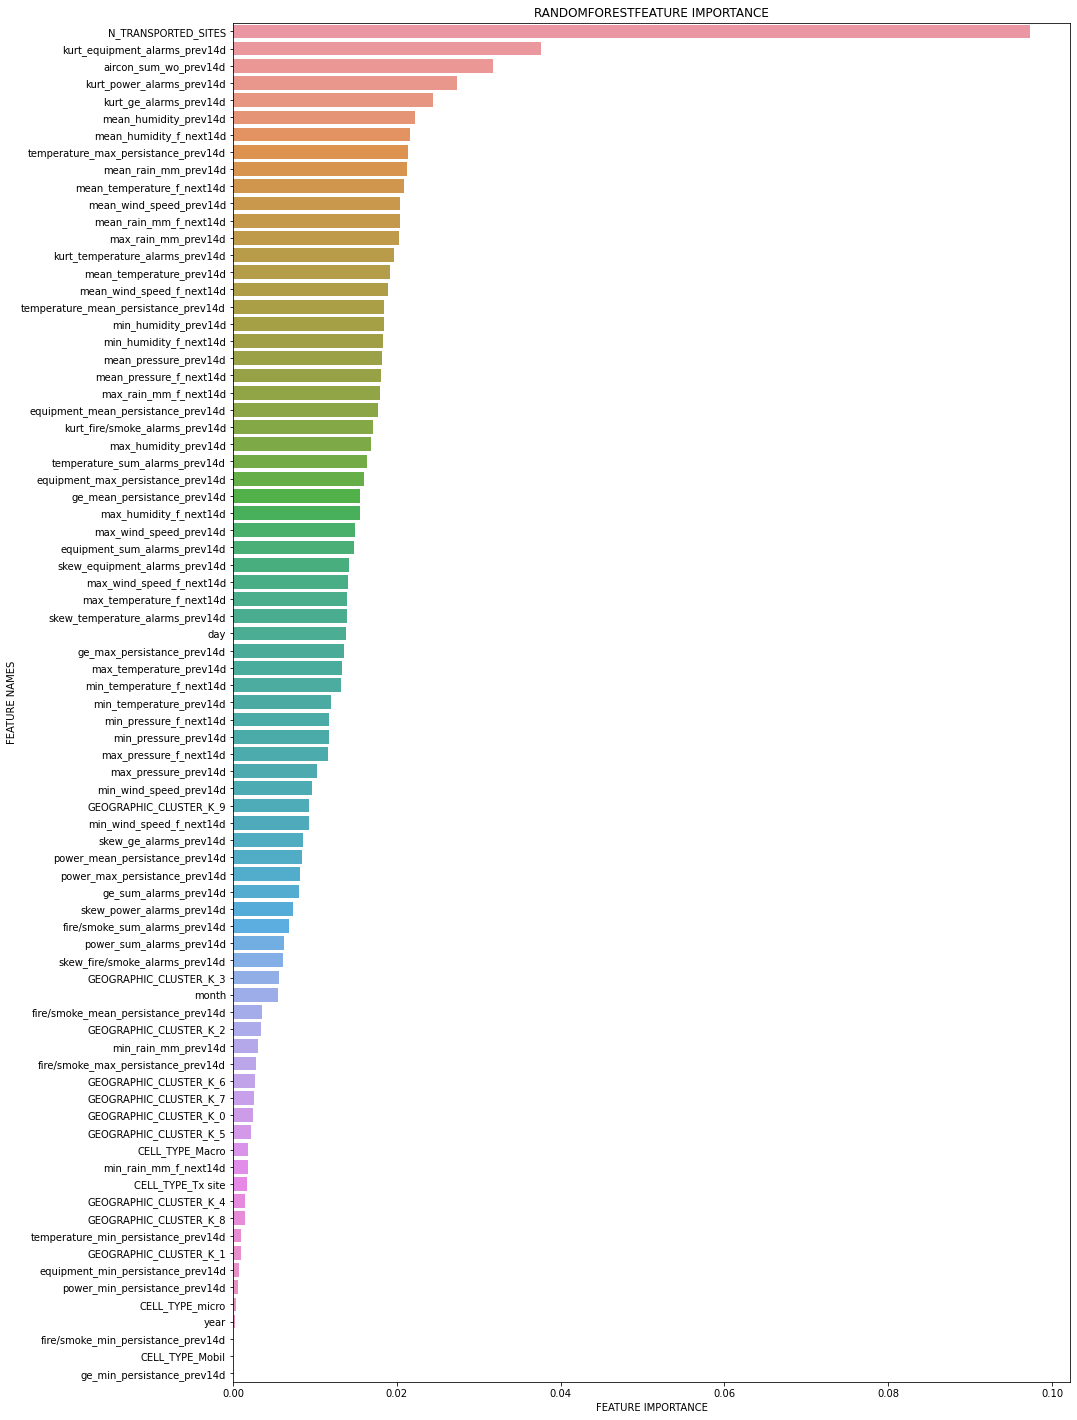

In [12]:
plot_feature_importance(clf_RandomForest.feature_importances_,X.columns, 'RANDOMFOREST')

#Random forest 7d

Random forest using only the feature with 7day time frame

In [15]:
df_7d = df[[col for col in df.columns if '3d' not in col and '14d' not in col]]
df_7d.head()

,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_wind_speed_prev7d,max_wind_speed_prev7d,min_wind_speed_prev7d,mean_pressure_prev7d,max_pressure_prev7d,min_pressure_prev7d,mean_temperature_f_next7d,max_temperature_f_next7d,min_temperature_f_next7d,mean_rain_mm_f_next7d,max_rain_mm_f_next7d,min_rain_mm_f_next7d,mean_humidity_f_next7d,max_humidity_f_next7d,min_humidity_f_next7d,mean_wind_speed_f_next7d,max_wind_speed_f_next7d,min_wind_speed_f_next7d,mean_pressure_f_next7d,max_pressure_f_next7d,min_pressure_f_next7d,equipment_sum_alarms_prev7d,fire/smoke_sum_alarms_prev7d,ge_sum_alarms_prev7d,power_sum_alarms_prev7d,temperature_sum_alarms_prev7d,equipment_max_persistance_prev7d,equipment_mean_persistance_prev7d,equipment_min_persistance_prev7d,fire/smoke_max_persistance_prev7d,fire/smoke_mean_persistance_prev7d,fire/smoke_min_persistance_prev7d,ge_max_persistance_prev7d,ge_mean_persistance_prev7d,ge_min_persistance_prev7d,power_max_persistance_prev7d,power_mean_persistance_prev7d,power_min_persistance_prev7d,temperature_max_persistance_prev7d,temperature_mean_persistance_prev7d,temperature_min_persistance_prev7d,month,day,year
0,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,10.29,14.0,6.0,1.33,8.5,0.0,62.71,81.0,45.0,11.43,16.0,5.0,1013.00,1022.0,1006.0,6.14,9.0,5.0,6.41,19.6,0.2,80.00,89.0,63.0,13.86,17.0,10.0,1016.14,1020.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,10,0
1,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,11.71,16.0,9.0,1.90,8.5,0.0,66.43,81.0,51.0,11.57,16.0,5.0,1010.86,1017.0,1006.0,5.86,8.0,5.0,4.63,12.5,0.2,79.86,89.0,63.0,13.29,17.0,10.0,1018.71,1027.0,1013.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,11,0
2,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,11.57,16.0,9.0,4.70,19.6,0.0,71.71,88.0,58.0,11.71,16.0,5.0,1009.71,1015.0,1006.0,6.29,11.0,5.0,5.61,12.5,0.2,78.43,89.0,63.0,13.57,17.0,10.0,1020.57,1027.0,1016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,12,0
3,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,11.29,16.0,8.0,4.77,19.6,0.0,74.29,88.0,58.0,11.43,16.0,5.0,1009.43,1013.0,1006.0,6.86,11.0,5.0,5.27,12.5,0.2,75.14,89.0,63.0,13.14,17.0,9.0,1022.29,1028.0,1017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,13,0
4,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,10.57,16.0,5.0,5.39,19.6,0.3,77.29,88.0,58.0,10.86,15.0,5.0,1009.86,1016.0,1006.0,7.86,12.0,5.0,5.23,12.5,0.2,72.86,89.0,63.0,11.71,17.0,5.0,1023.00,1028.0,1018.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,14,0


In [16]:
X = df_7d
y = df['aircon_sum_target_next14d']

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0, stratify = y)

clf_RandomForest = RandomForestClassifier(n_estimators = 20, random_state=0)
clf_RandomForest.fit(X_train, y_train)
y_pred = clf_RandomForest.predict(X_test)

Accuracy:  0.9950040238210205
Precision:  0.6986754966887417
Recall:  0.23549107142857142
F1 score:  0.3522537562604341


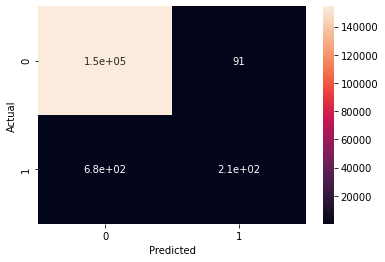

In [18]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Precision: ',metrics.precision_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred))
print('F1 score: ',metrics.f1_score(y_test, y_pred))

plt.show()

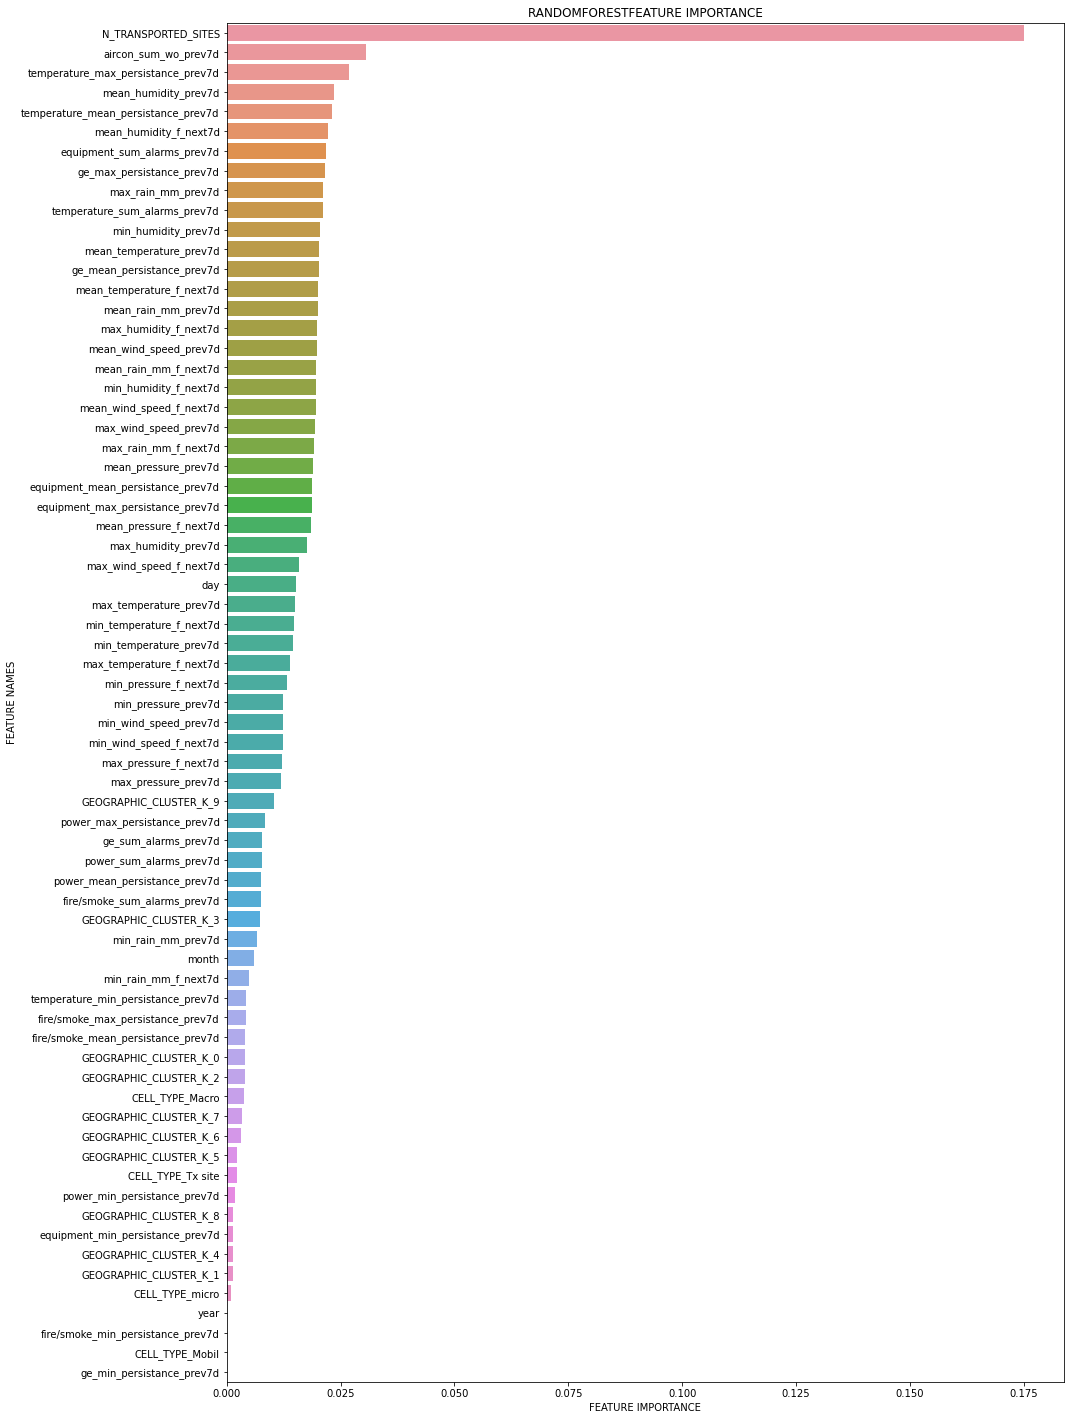

In [19]:
plot_feature_importance(clf_RandomForest.feature_importances_,X.columns, 'RANDOMFOREST')

#Random forest 3d

Random forest using only the feature with 3day time frame

In [20]:
df_3d = df[[col for col in df.columns if '14d' not in col and '7d' not in col]]
df_3d.head()

,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev3d,max_wind_speed_prev3d,min_wind_speed_prev3d,mean_pressure_prev3d,max_pressure_prev3d,min_pressure_prev3d,equipment_sum_alarms_prev3d,fire/smoke_sum_alarms_prev3d,ge_sum_alarms_prev3d,power_sum_alarms_prev3d,temperature_sum_alarms_prev3d,equipment_max_persistance_prev3d,equipment_mean_persistance_prev3d,equipment_min_persistance_prev3d,fire/smoke_max_persistance_prev3d,fire/smoke_mean_persistance_prev3d,fire/smoke_min_persistance_prev3d,ge_max_persistance_prev3d,ge_mean_persistance_prev3d,ge_min_persistance_prev3d,power_max_persistance_prev3d,power_mean_persistance_prev3d,power_min_persistance_prev3d,temperature_max_persistance_prev3d,temperature_mean_persistance_prev3d,temperature_min_persistance_prev3d,month,day,year
0,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,12.00,14.0,9.0,3.10,8.5,0.3,70.67,81.0,58.0,8.00,12.0,5.0,1008.00,1010.0,1006.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,10,0
1,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,13.00,16.0,9.0,4.27,8.5,0.3,75.00,81.0,71.0,8.00,12.0,5.0,1007.00,1008.0,1006.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,11,0
2,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,13.00,16.0,9.0,7.97,19.6,0.3,77.33,88.0,71.0,10.67,15.0,5.0,1007.33,1009.0,1006.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,12,0
3,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,11.00,16.0,8.0,8.03,19.6,0.5,80.33,88.0,71.0,13.33,15.0,12.0,1009.67,1013.0,1007.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,13,0
4,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,7.33,9.0,5.0,8.13,19.6,0.5,86.00,88.0,82.0,13.33,15.0,12.0,1012.67,1016.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,14,0


In [21]:
X = df_3d
y = df['aircon_sum_target_next14d']

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0, stratify = y)

clf_RandomForest = RandomForestClassifier(n_estimators = 20, random_state=0)
clf_RandomForest.fit(X_train, y_train)
y_pred = clf_RandomForest.predict(X_test)

Accuracy:  0.9937357154353774
Precision:  0.2824858757062147
Recall:  0.05580357142857143
F1 score:  0.09319664492078285


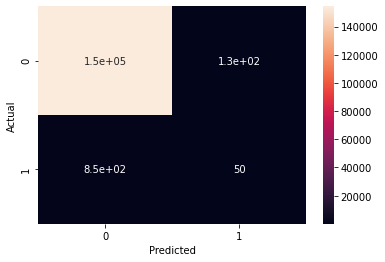

In [23]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Precision: ',metrics.precision_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred))
print('F1 score: ',metrics.f1_score(y_test, y_pred))

plt.show()

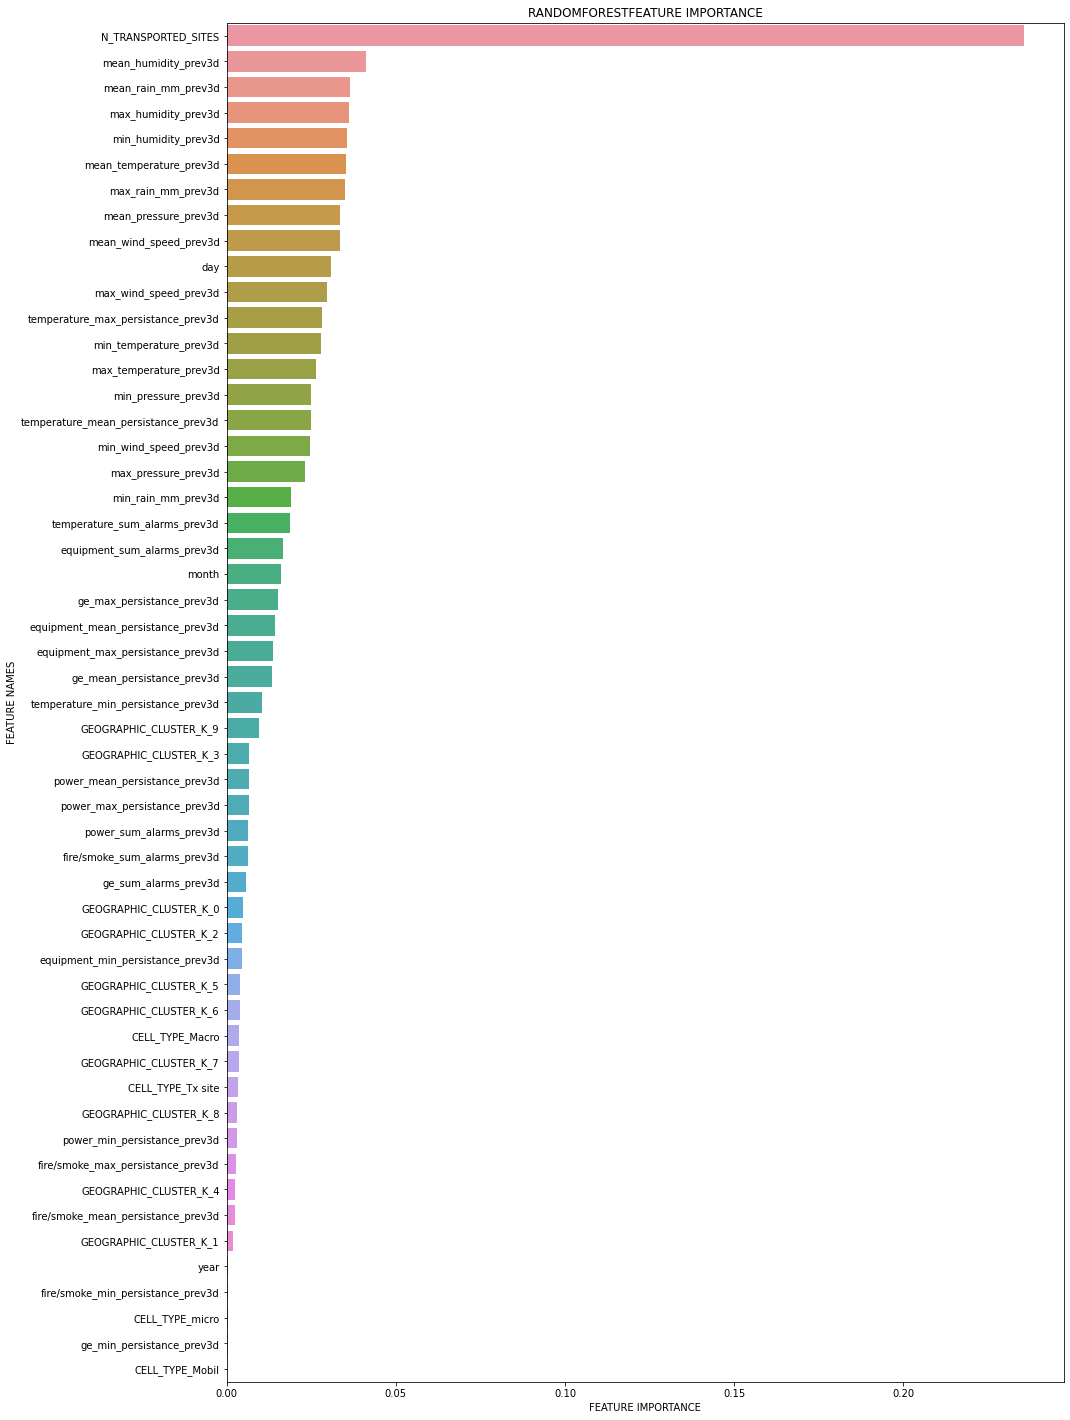

In [24]:
plot_feature_importance(clf_RandomForest.feature_importances_,X.columns, 'RANDOMFOREST')